In [1]:
import torch
import torchvision
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
import os
from tqdm import tqdm

In [2]:
weights = ResNet50_Weights.DEFAULT
transforms = weights.transforms()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available() == True

model = resnet50(weights=weights).to(device=device)

In [3]:
final_transforms = torchvision.transforms.Compose([ 
                    torchvision.transforms.Lambda(lambda x: x.convert("RGB")),
                    transforms])

dataset = MNIST(root="/home/jurica/Desktop/projekt", transform=final_transforms, download=True)
test_set = MNIST(root="/home/jurica/Desktop/projekt", transform=final_transforms, train=False, download=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


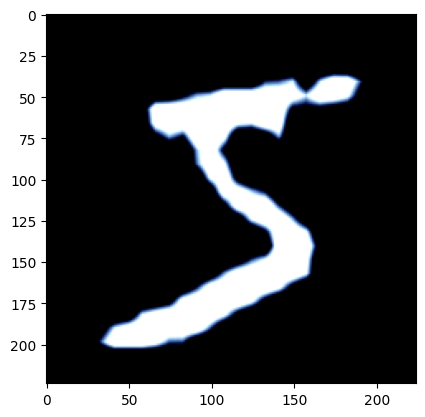

In [4]:
plt.imshow(dataset[0][0].numpy().transpose(1,2,0))

In [5]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=2048, out_features=10, bias=True).to(device=device)

In [6]:
def train(model, device, dataset, epochs, 
          batch_size, learning_rate, weight_decay, 
          momentum, train_loss, train_acc):

    train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=os.cpu_count(),
                              pin_memory=True, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, fused=True)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()

        with tqdm(total=len(dataset), desc=f"Epoch {epoch}/{epochs}", unit="img") as progress:
            for batch in train_loader:
                images = batch[0].to(device=device, memory_format=torch.channels_last)
                label = batch[1].to(device=device)

                pred_label = model(images)

                loss = criterion(pred_label, label)

                train_loss.append(loss.item())

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                
                progress.update(images.shape[0])
                
                train_acc.append((pred_label.argmax(dim=1) == label).float().mean().item())

        state_dict = model.state_dict()
        torch.save(state_dict, f"/home/jurica/Desktop/projekt/mnist_check/checkpoint_epoch{epoch}.pth")

In [7]:
train_loss, train_acc = [], []

train(model,
      device, 
      dataset, 
      epochs=10, 
      batch_size=128, 
      learning_rate=0.001, 
      weight_decay=1e-5,
      momentum=0.999,
      train_loss=train_loss,
      train_acc=train_acc
     )

Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████| 60000/60000 [02:24<00:00, 416.23img/s]


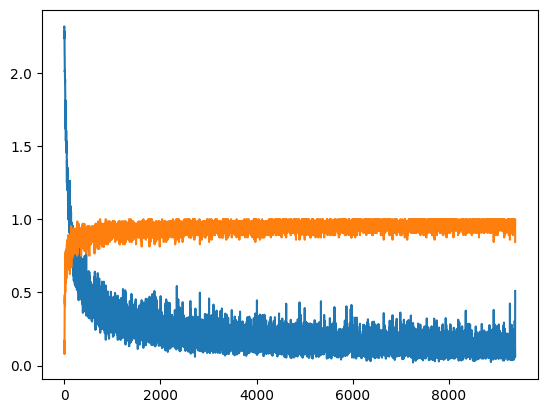

In [16]:
plt.plot(train_loss)
plt.plot(train_acc)

In [9]:
state_dict = torch.load("/home/jurica/Desktop/projekt/mnist_check/checkpoint_epoch10.pth", map_location=device)
model.load_state_dict(state_dict)

test_loss, test_acc = [], []

test_loader = DataLoader(test_set, batch_size=128, num_workers=os.cpu_count(),
                         pin_memory=True, shuffle=True)

with torch.inference_mode():
    model.eval()
    with tqdm(total=len(test_set), unit="img") as progress:
        for batch in test_loader:
            images = batch[0].to(device=device, memory_format=torch.channels_last)
            label = batch[1].to(device=device)    

            pred_label = model(images)

            loss = nn.CrossEntropyLoss()(pred_label, label)

            test_loss.append(loss.item())
            
            progress.update(images.shape[0])
                
            test_acc.append((pred_label.argmax(dim=1) == label).float().mean().item())

100%|████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.41img/s]


In [10]:
np.array(test_loss).mean()

0.15602477751434987

In [11]:
np.array(test_acc).mean()

0.95421974522293

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


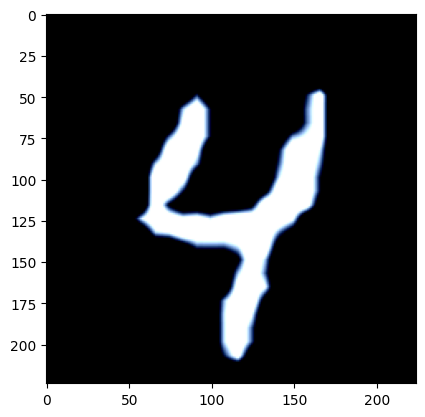

In [12]:
img, label = test_set[1111]

plt.imshow(img.numpy().transpose(1,2,0))

In [13]:
print(f"label: {label}")

with torch.inference_mode():
    model.eval()
    pred = model(img.unsqueeze(0).to(device=device))
    pred_label = pred.softmax(dim=1).argmax(dim=1).item()
    print(f"predicted label: {pred_label}")
    print(f"predicted probability: {pred.softmax(dim=1).squeeze()[pred_label]}")

label: 4
predicted label: 4
predicted probability: 0.9979998469352722


In [14]:
torchinfo.summary(model, input_size=(1, 3, 224, 224), 
                  col_names=("input_size",
                             "output_size",
                             "num_params",
                             "trainable",))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [1, 3, 224, 224]          [1, 10]                   --                        Partial
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         (128)                     False
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 256, 56, 56]          --                        False
│    └─Bottleneck: 2-1                   [1, 64, 56, 56]           [1, 256, 56, 56]          --                        False
